In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
DOWNLOAD_PATH = "./data/temp/"
DATA_PATH = "./data"
ZIP_NAME = "fer2013.zip"
TEMP_ZIP_FILE_PATH = os.path.join(DOWNLOAD_PATH, ZIP_NAME)
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [3]:
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

!curl -L -o {TEMP_ZIP_FILE_PATH} https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

with zipfile.ZipFile(TEMP_ZIP_FILE_PATH, "r") as zip:
    zip.extractall(DATA_PATH)

os.remove(TEMP_ZIP_FILE_PATH)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  3821k      0  0:00:16  0:00:16 --:--:-- 4173k


In [3]:
def load_dataset(PATH):
    CLASS_NAMES = sorted(os.listdir(PATH))
    LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    
    images = []
    labels = []
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(LABEL_MAP[class_name])
    images = np.array(images)
    labels = np.array(labels)
    images, labels = shuffle(images, labels, random_state=42)
    return images, labels, LABEL_MAP

In [4]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

def create_cnn_model(base_model, OUTPUT_SIZE):
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(OUTPUT_SIZE, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [26]:
import os
import matplotlib.pyplot as plt

def show_train_loss_accuracy(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history.history['loss'], label='Loss Treino')
    axes[0].plot(history.history['val_loss'], label='Loss Validação')
    axes[0].set_title(f'Loss - {model_name}')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Acurácia Treino')
        axes[1].plot(history.history['val_accuracy'], label='Acurácia Validação')
        axes[1].set_title(f'Acurácia - {model_name}')
        axes[1].set_xlabel('Época')
        axes[1].set_ylabel('Acurácia')
        axes[1].legend()
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Acurácia não disponível', ha='center', va='center')

    plt.tight_layout()

    save_dir = os.path.join(model_name, "metrics", "training")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "accuracy_loss_plot_flatten_completo.png")
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [7]:
from tensorflow.keras.applications import VGG19, DenseNet201, ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

OUTPUT_CLASSES = 7
INPUT_SHAPE = (48, 48, 3)

def get_callbacks(model_name):
    return [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint(f'{model_name}/best_{model_name}_model_flatten.keras', monitor='accuracy', save_best_only=True)
]


resnet50v2 = create_cnn_model(
    ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

denseNet201 = create_cnn_model(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

vgg19 = create_cnn_model(VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}

2025-08-15 08:15:54.634688: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

for model_name, model in models.items():
    print(f"STRAT TRAINING MODEL {model_name}...")
    histories[model_name] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks(model_name))
    print(f"FINISH TRAINING MODEL {model_name}!")
    print("---------------------------------------------------------------")

STRAT TRAINING MODEL ResNet50v2...
Epoch 1/60


2025-08-15 08:16:09.929689: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 634991616 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2049 - loss: 2.6225

2025-08-15 08:17:39.560348: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 158754816 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.2363 - loss: 2.4484 - val_accuracy: 0.3445 - val_loss: 1.7634 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 101s 141ms/step - accuracy: 0.2921 - loss: 2.0943 - val_accuracy: 0.3732 - val_loss: 1.6738 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 99s 138ms/step - accuracy: 0.3221 - loss: 1.9398 - val_accuracy: 0.3776 - val_loss: 1.6263 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.3429 - loss: 1.8261 - val_accuracy: 0.3932 - val_loss: 1.5937 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - accuracy: 0.3529 - loss: 1.7560 - val_accuracy: 0.3995 - val_loss: 1.5728 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 145s 134ms/step - accuracy: 0.3714 - loss: 1.6873 - val_accuracy: 0.3990 - val_loss: 1.5651 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 99s 137ms/step 

2025-08-15 08:56:15.326988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 634991616 exceeds 10% of free system memory.


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2117 - loss: 2.6146

2025-08-15 08:58:28.698920: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 158754816 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 173s 193ms/step - accuracy: 0.2428 - loss: 2.4367 - val_accuracy: 0.3534 - val_loss: 1.7335 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 138s 192ms/step - accuracy: 0.3143 - loss: 2.0394 - val_accuracy: 0.3943 - val_loss: 1.6377 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 148s 206ms/step - accuracy: 0.3367 - loss: 1.8891 - val_accuracy: 0.3967 - val_loss: 1.5867 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 144s 201ms/step - accuracy: 0.3565 - loss: 1.7820 - val_accuracy: 0.4046 - val_loss: 1.5521 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 144s 200ms/step - accuracy: 0.3783 - loss: 1.7019 - val_accuracy: 0.4201 - val_loss: 1.5242 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 144s 200ms/step - accuracy: 0.3870 - loss: 1.6471 - val_accuracy: 0.4190 - val_loss: 1.5082 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 144s 200ms/

2025-08-15 10:05:32.403618: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 634991616 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 225s 307ms/step - accuracy: 0.2254 - loss: 2.4591 - val_accuracy: 0.3474 - val_loss: 1.7473 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 288s 343ms/step - accuracy: 0.2725 - loss: 2.1269 - val_accuracy: 0.3703 - val_loss: 1.6689 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 232s 323ms/step - accuracy: 0.3029 - loss: 1.9645 - val_accuracy: 0.3718 - val_loss: 1.6263 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 299s 417ms/step - accuracy: 0.3168 - loss: 1.8559 - val_accuracy: 0.3797 - val_loss: 1.6041 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 306s 395ms/step - accuracy: 0.3275 - loss: 1.7862 - val_accuracy: 0.3828 - val_loss: 1.5816 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 277s 385ms/step - accuracy: 0.3354 - loss: 1.7500 - val_accuracy: 0.3920 - val_loss: 1.5681 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 319s 381ms/

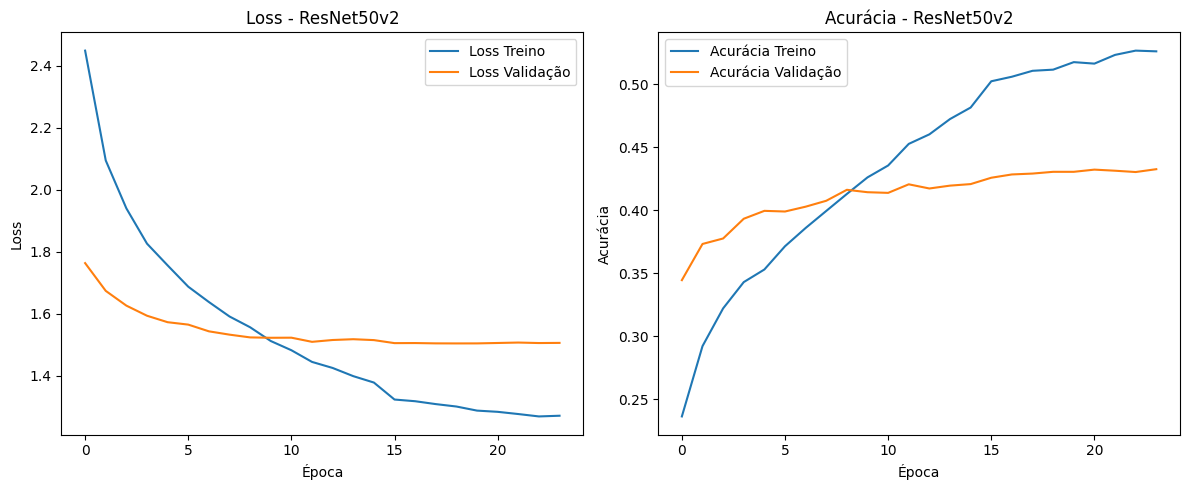

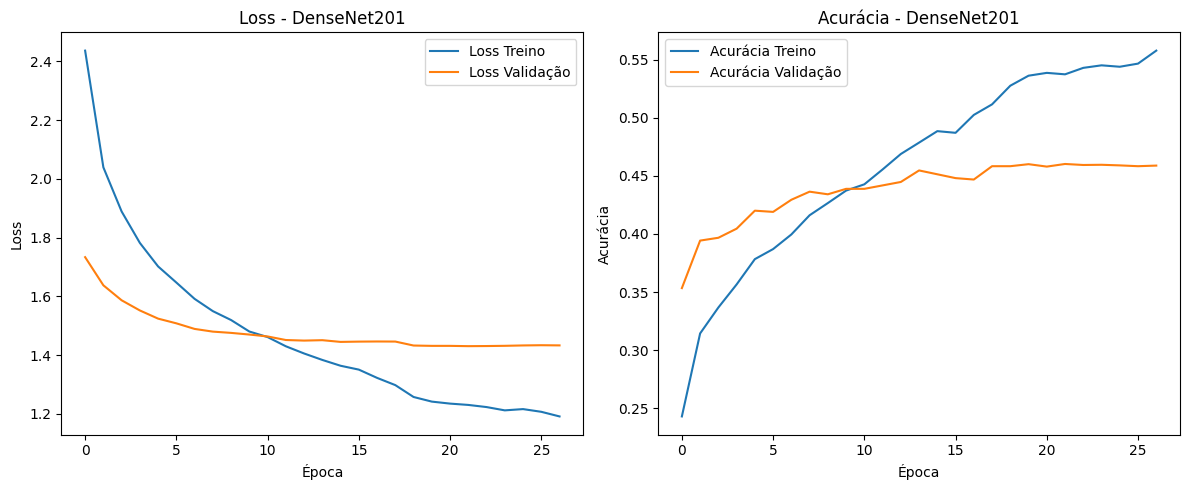

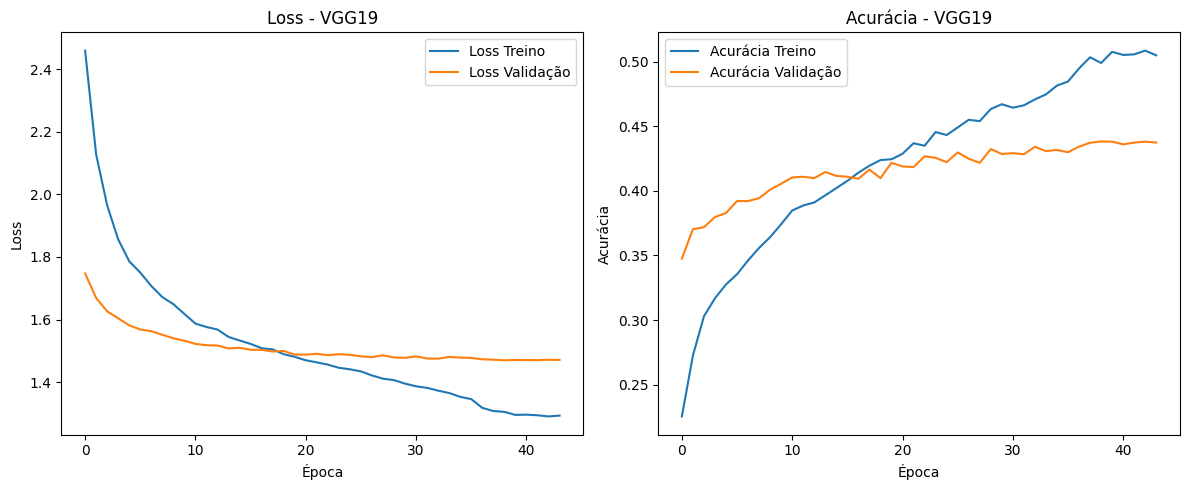

In [27]:
for model_name, history in histories.items():
    show_train_loss_accuracy(history, model_name)

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

def show_metrics(y_true, y_pred, model_name, is_test=False):
    classes_emocao = list(LABEL_MAP.keys())
    class_acc = {}

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Métricas do modelo: {model_name}")
    print("Accuracy Score:  ", round(acc, 4))
    print("Precision Score: ", round(prec, 4))
    print("Recall Score:    ", round(rec, 4))
    print("F1 Score:        ", round(f1, 4))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))
    
    for i, emotion in enumerate(classes_emocao):
        idx = np.where(y_true == i)[0]
        correct = np.sum(y_pred[idx] == y_true[idx])
        class_acc[emotion] = correct / len(idx)
    
    print('\nAcurácia por classe:')
    for emotion, acc in class_acc.items():
        print(f'- {emotion}: {acc:.2%}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes_emocao, 
                yticklabels=classes_emocao)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

    save_dir = os.path.join(model_name, "metrics", "flatten")
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f"{"test_" if is_test else "train_"}confusion_matrix_completa.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [11]:
def get_preds(X, model):
    y = model.predict(X)
    return np.argmax(y, axis=1)

In [23]:
y_preds = {}
for model_name, model in models.items():
    y_preds[model_name] = get_preds(X_train_resized, model)

898/898 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 86s 96ms/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 191s 213ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.5732
Precision Score:  0.6259
Recall Score:     0.5033
F1 Score:         0.5221

Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.42      0.48      3995
           1       0.92      0.17      0.29       436
           2       0.58      0.39      0.46      4097
           3       0.58      0.79      0.67      7215
           4       0.55      0.54      0.55      4965
           5       0.51      0.55      0.53      4830
           6       0.68      0.67      0.68      3171

    accuracy                           0.57     28709
   macro avg       0.63      0.50      0.52     28709
weighted avg       0.58      0.57      0.56     28709


Acurácia por classe:
- angry: 41.55%
- disgust: 17.43%
- fear: 38.78%
- happy: 78.50%
- neutral: 54.32%
- sad: 54.87%
- surprise: 66.86%


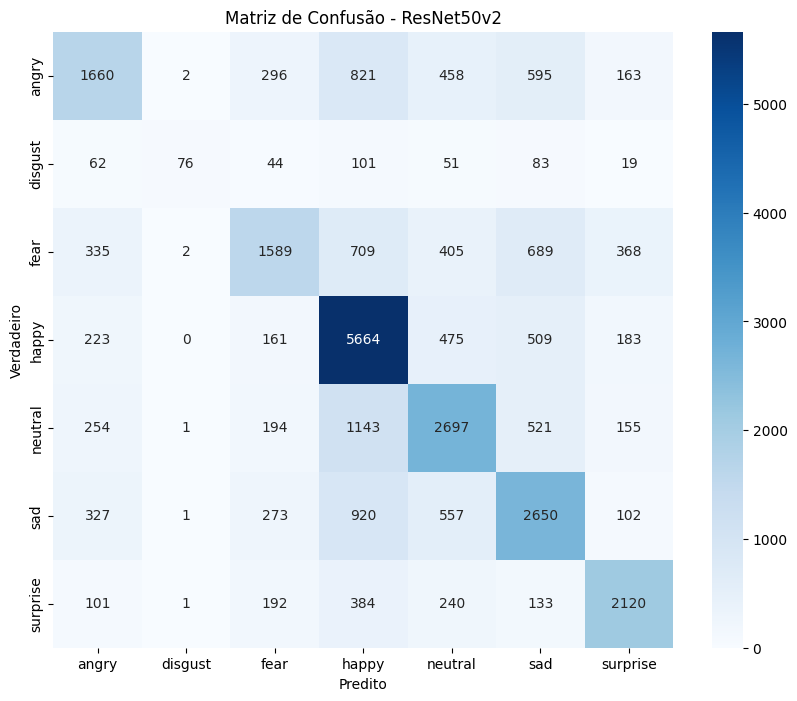

Métricas do modelo: DenseNet201
Accuracy Score:   0.6083
Precision Score:  0.6431
Recall Score:     0.556
F1 Score:         0.5781

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.48      0.53      3995
           1       0.86      0.32      0.46       436
           2       0.60      0.47      0.53      4097
           3       0.63      0.80      0.70      7215
           4       0.57      0.58      0.57      4965
           5       0.56      0.53      0.54      4830
           6       0.70      0.72      0.71      3171

    accuracy                           0.61     28709
   macro avg       0.64      0.56      0.58     28709
weighted avg       0.61      0.61      0.60     28709


Acurácia por classe:
- angry: 47.76%
- disgust: 31.65%
- fear: 47.11%
- happy: 80.33%
- neutral: 57.70%
- sad: 52.73%
- surprise: 71.93%


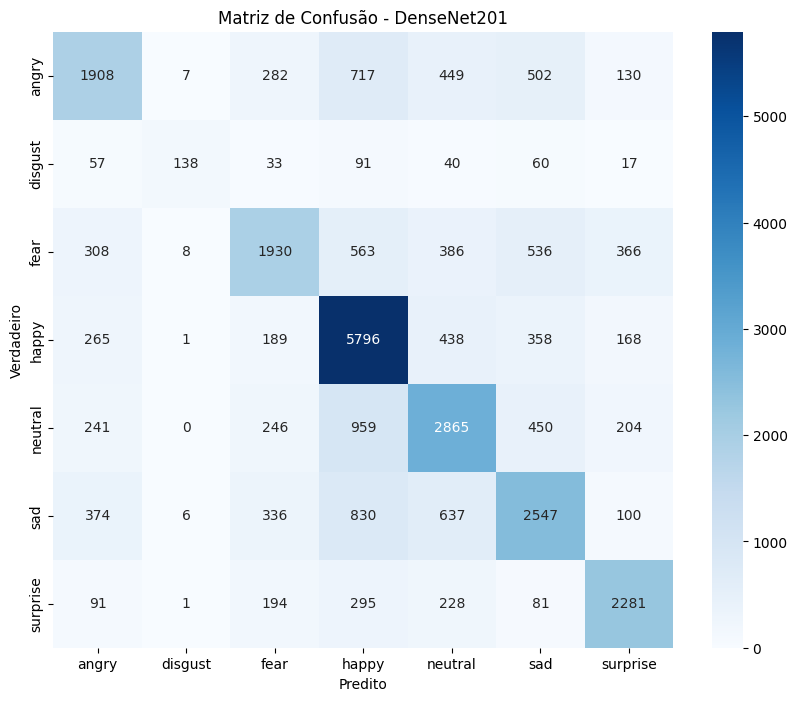

Métricas do modelo: VGG19
Accuracy Score:   0.5527
Precision Score:  0.6087
Recall Score:     0.5152
F1 Score:         0.54

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.42      0.47      3995
           1       0.87      0.39      0.54       436
           2       0.60      0.34      0.43      4097
           3       0.55      0.77      0.64      7215
           4       0.50      0.53      0.52      4965
           5       0.50      0.47      0.48      4830
           6       0.72      0.68      0.70      3171

    accuracy                           0.55     28709
   macro avg       0.61      0.52      0.54     28709
weighted avg       0.56      0.55      0.54     28709


Acurácia por classe:
- angry: 42.20%
- disgust: 39.22%
- fear: 33.56%
- happy: 76.95%
- neutral: 53.45%
- sad: 46.75%
- surprise: 68.50%


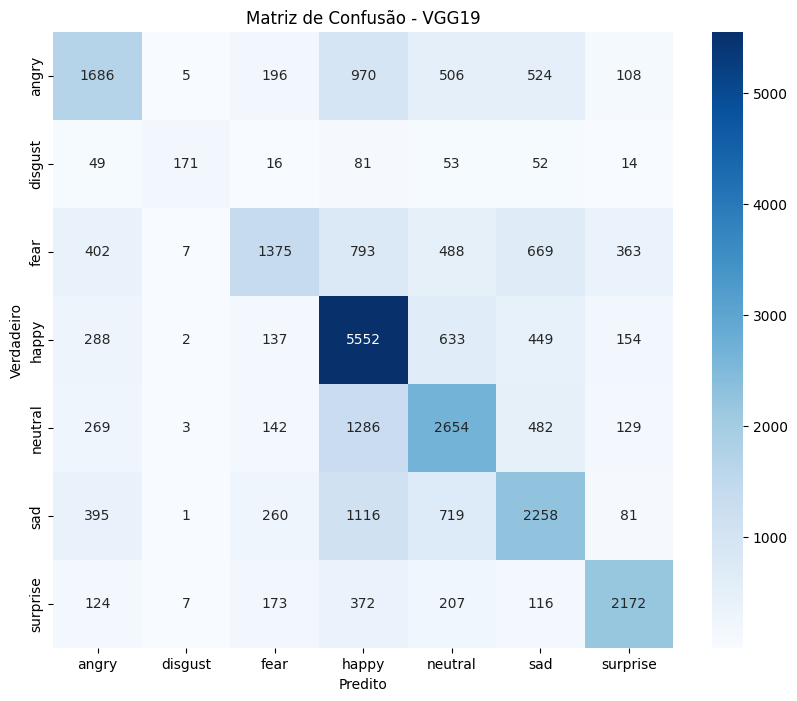

In [24]:
metrics = {}
for model_name, preds in y_preds.items():
    metrics[model_name] = show_metrics(y_train, preds, model_name)

In [14]:
y_preds_teste = {}
for model_name, model in models.items():
    y_preds_teste[model_name] = get_preds(X_test_resized, model)

225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.4393
Precision Score:  0.4928
Recall Score:     0.3725
F1 Score:         0.3783

Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.24      0.28       958
           1       0.90      0.08      0.15       111
           2       0.36      0.22      0.27      1024
           3       0.51      0.69      0.58      1774
           4       0.40      0.40      0.40      1233
           5       0.35      0.39      0.37      1247
           6       0.60      0.59      0.59       831

    accuracy                           0.44      7178
   macro avg       0.49      0.37      0.38      7178
weighted avg       0.43      0.44      0.42      7178


Acurácia por classe:
- angry: 24.22%
- disgust: 8.11%
- fear: 22.27%
- happy: 68.88%
- neutral: 39.90%
- sad: 38.65%
- surprise: 58.72%


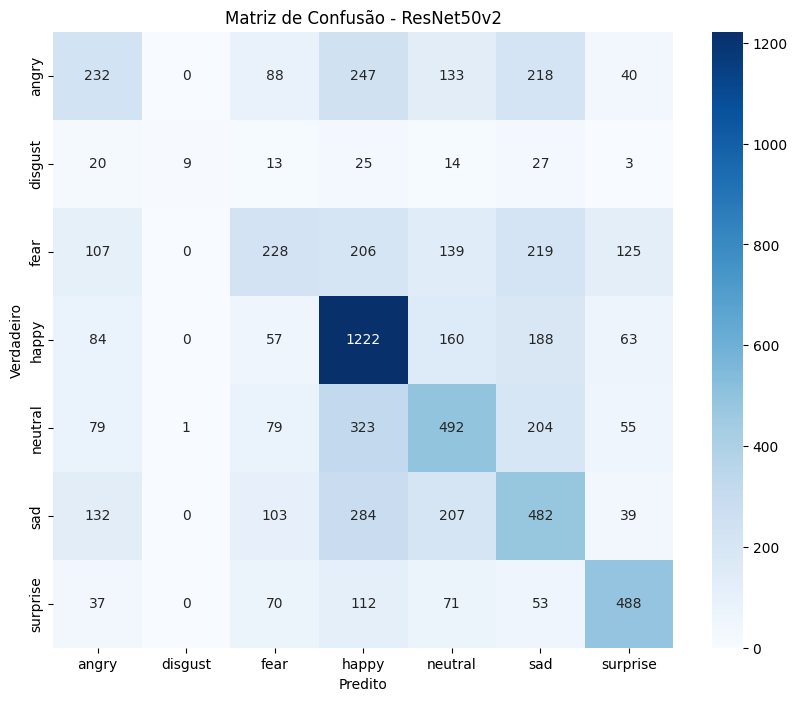

Métricas do modelo: DenseNet201
Accuracy Score:   0.456
Precision Score:  0.4725
Recall Score:     0.4008
F1 Score:         0.412

Classification Report:

              precision    recall  f1-score   support

           0       0.35      0.29      0.31       958
           1       0.67      0.16      0.26       111
           2       0.38      0.30      0.33      1024
           3       0.53      0.69      0.60      1774
           4       0.40      0.42      0.41      1233
           5       0.39      0.35      0.37      1247
           6       0.60      0.60      0.60       831

    accuracy                           0.46      7178
   macro avg       0.47      0.40      0.41      7178
weighted avg       0.45      0.46      0.45      7178


Acurácia por classe:
- angry: 28.71%
- disgust: 16.22%
- fear: 29.59%
- happy: 69.11%
- neutral: 41.52%
- sad: 35.12%
- surprise: 60.29%


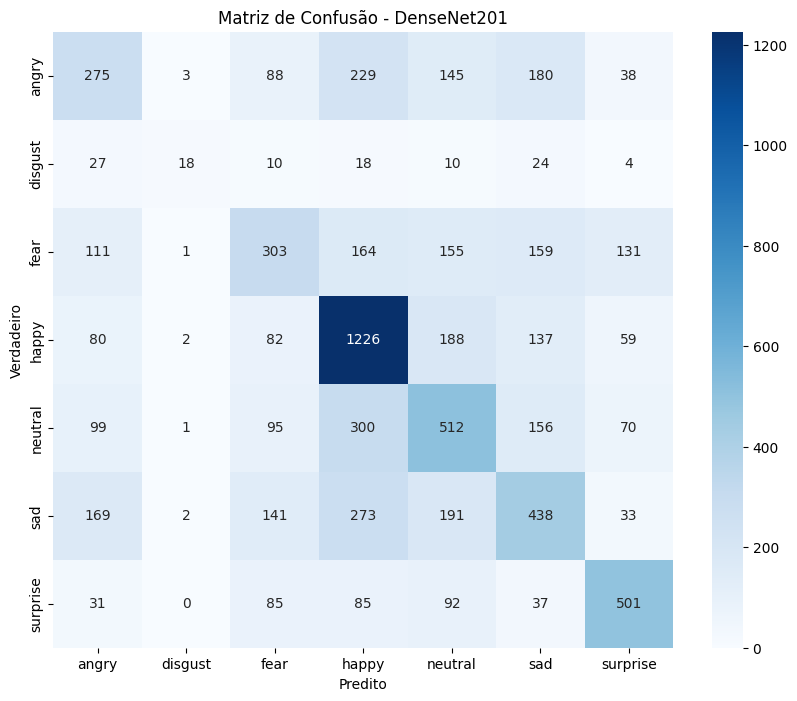

Métricas do modelo: VGG19
Accuracy Score:   0.4376
Precision Score:  0.4718
Recall Score:     0.398
F1 Score:         0.4136

Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.30      0.32       958
           1       0.70      0.27      0.39       111
           2       0.41      0.21      0.28      1024
           3       0.47      0.68      0.56      1774
           4       0.38      0.40      0.39      1233
           5       0.37      0.34      0.35      1247
           6       0.63      0.59      0.61       831

    accuracy                           0.44      7178
   macro avg       0.47      0.40      0.41      7178
weighted avg       0.43      0.44      0.42      7178


Acurácia por classe:
- angry: 29.85%
- disgust: 27.03%
- fear: 21.00%
- happy: 67.70%
- neutral: 40.31%
- sad: 34.08%
- surprise: 58.60%


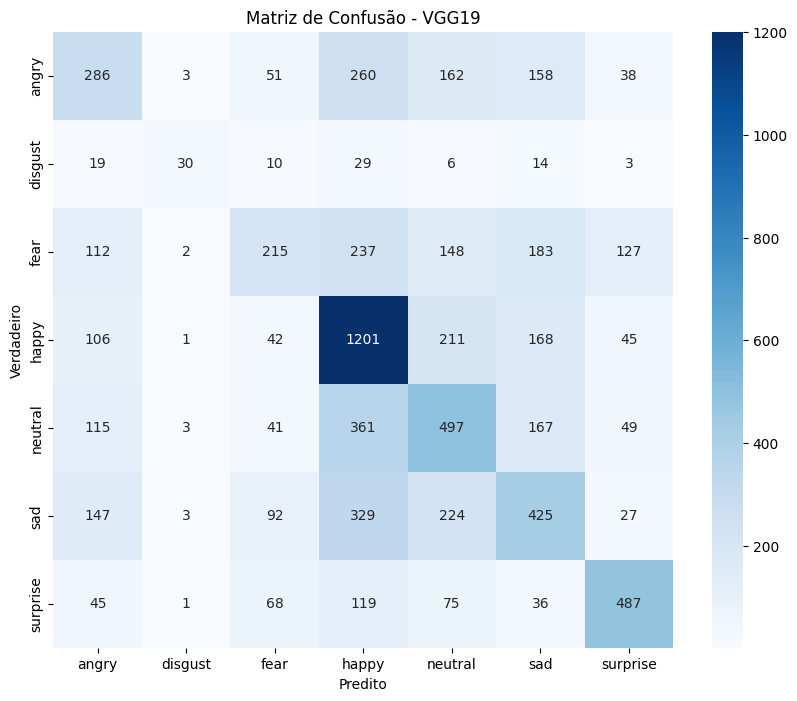

In [25]:
metrics_teste = {}
for model_name, preds in y_preds_teste.items():
    metrics_teste[model_name] = show_metrics(y_test, preds, model_name, is_test=True)